# Geographic Manipulations Part I #
In order to compare accidents, I need to create a database of locations, scored by accidents that occur there.

The first thing I need to do is create clusters of bike accidents.

In [1]:
import pandas as pd
import geopandas as gpd
import json
import glob
from shapely.geometry import Point, LineString, Polygon
from pyproj import Proj, transform
from matplotlib import pyplot as plt

In [2]:
# Read in cleaned up bike accident data
bike_df = pd.read_csv('data/cleaned_data/bike_accident_clean.csv')

In [3]:
# I'm going to build a brand new dataframe organized by clusters instead of individual accidents
# Every accident must have been within 50m of every other accident in the cluster

# Create list of points and lines and ids
acc_clusters = []

# Iterate through every bike accident
for index, row in bike_df.iterrows():
    # For first accident, create the first cluster, of one point, with a 50m buffer around it
    if (index == 0):
        point = Point(row['Xkm'], row['Ykm'])
        acc_clusters.append({'shape': point, 'accident_ids': [row['ID']], 'buffer': point.buffer(50)})
    else: 
        # For all subsequent accidents, find out if any of the existing accident clusters contain
        # the accident, and if so, add it to that cluster. If not, create a new cluster
        cluster_found = False
        for counter, item in enumerate(acc_clusters):
            point = Point(row['Xkm'], row['Ykm'])
            if (point.within(item['buffer'])):
                cluster_found = True
                if (item['shape'].geom_type == 'Point'):
                    new_shape = LineString([item['shape'], point])
                else:
                    point_list = list(item['shape'].coords)
                    point_list.append(point)
                    new_shape = LineString(point_list)
                new_buffer = new_shape.buffer(50)
                acc_clusters[counter]['accident_ids'].append(row['ID'])
                acc_clusters[counter]['shape'] = new_shape
                acc_clusters[counter]['buffer'] = new_buffer
        if not cluster_found:
            acc_clusters.append({'shape': point, 'accident_ids': [row['ID']], 'buffer': point.buffer(50)})


That was fairly time-consuming, so I'll output the cluster data to a file so I don't have to do it again

In [4]:
# convert to geopandas dataframe
acc_clusters_df = gpd.GeoDataFrame(acc_clusters)

# output to file
acc_clusters_df.to_csv(r'data/cleaned_data/bike_clusters.csv')


Here is what one of the buffer shapes looks like.

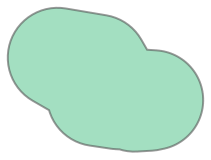

In [5]:
acc_clusters_df['buffer'].loc[0]

For fun, here are a few plots of the clusters, to make sure that the shapely code does what I want.

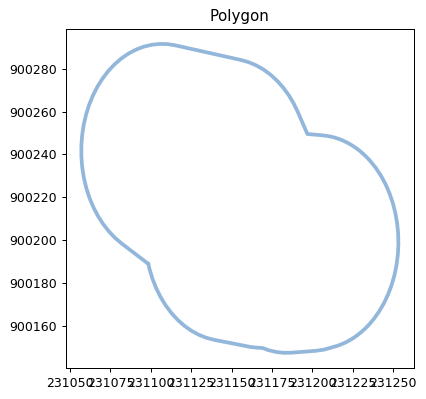

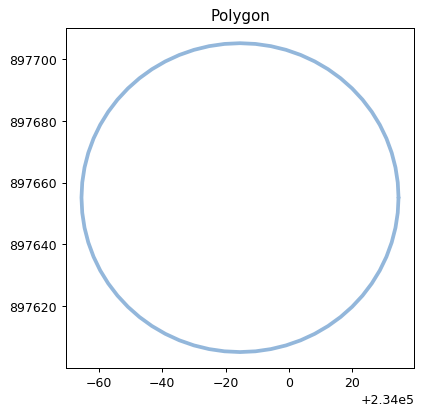

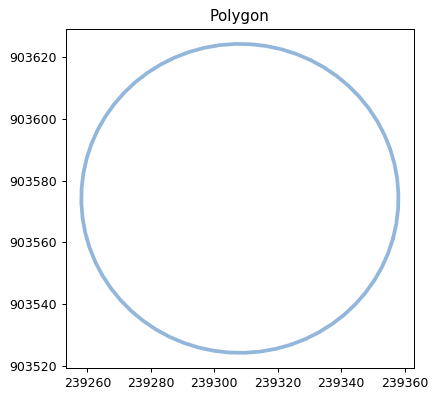

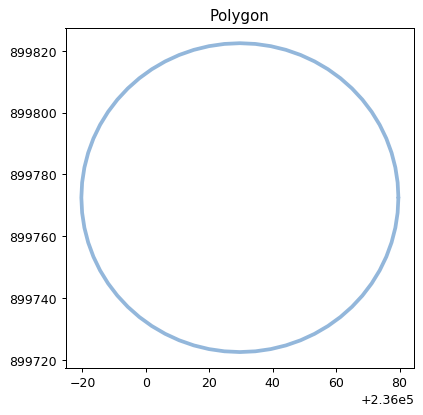

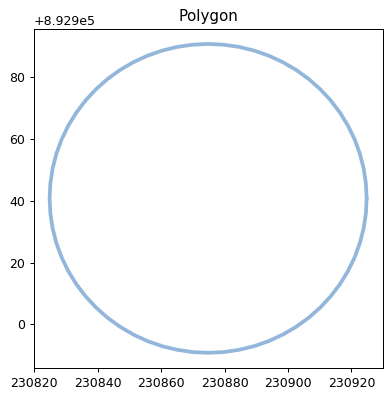

In [6]:
for i in range(5):
    x,y = acc_clusters[i]['buffer'].exterior.xy
    fig = plt.figure(i, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)
    ax.set_title('Polygon')